In [1]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append(str(Path.cwd().parent/'scripts'))
from _helpers import to_datetime

In [13]:
root = Path.cwd().parent / "resources" / "live_data"

prices = []
# bmus = []
timestamps = []

for fn in tqdm(os.listdir(root)):

    date, period = fn.split('_')
    date = to_datetime(date, period)

    files = os.listdir(root / fn)
    if 'elexon_bmus.csv' in files and 'price_stats.csv' in files:

        # bmu = pd.read_csv(root / fn / 'elexon_bmus.csv', index_col=0)
        # bmus.append(bmu[['PN']].rename(columns={'PN': date}))

        price = pd.read_csv(root / fn / 'price_stats.csv', index_col=0)
        if price.empty:
            continue

        prices.append(price.iloc[0,0])
        timestamps.append(date)

# bmus = pd.concat(bmus, axis=1).T
prices = pd.Series(prices, timestamps)
ts = prices.index

  0%|          | 0/9323 [00:00<?, ?it/s]

100%|██████████| 9323/9323 [00:47<00:00, 195.67it/s] 


In [48]:
bmus = pd.read_csv(
    Path.cwd().parent / 'data' / 'bmu_operation_winter.csv',
    index_col=0,
    parse_dates=True
    )

bmus.index = bmus.index.tz_localize('utc')
bmus.index

DatetimeIndex(['2023-10-01 01:00:00+00:00', '2023-10-01 05:30:00+00:00',
               '2023-10-01 06:00:00+00:00', '2023-10-01 06:30:00+00:00',
               '2023-10-01 07:00:00+00:00', '2023-10-01 07:30:00+00:00',
               '2023-10-01 08:00:00+00:00', '2023-10-01 08:30:00+00:00',
               '2023-10-01 09:00:00+00:00', '2023-10-01 09:30:00+00:00',
               ...
               '2024-04-06 22:30:00+00:00', '2024-04-06 23:00:00+00:00',
               '2024-04-06 23:30:00+00:00', '2024-04-07 00:00:00+00:00',
               '2024-04-07 00:30:00+00:00', '2024-04-06 03:00:00+00:00',
               '2024-04-06 03:30:00+00:00', '2024-04-06 04:00:00+00:00',
               '2024-04-06 04:30:00+00:00', '2024-04-06 05:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=8191, freq=None)

In [73]:
prices = pd.read_csv(
    Path.cwd().parent / 'data' / 'winter_202324_market_index.csv',
    index_col=0,
    parse_dates=True
    ).rename(columns={'Price': 'price'})["price"]
prices.sort_index(inplace=True)
prices.index

DatetimeIndex(['2023-10-01 00:00:00+00:00', '2023-10-01 00:30:00+00:00',
               '2023-10-01 01:00:00+00:00', '2023-10-01 01:30:00+00:00',
               '2023-10-01 02:00:00+00:00', '2023-10-01 02:30:00+00:00',
               '2023-10-01 03:00:00+00:00', '2023-10-01 03:30:00+00:00',
               '2023-10-01 04:00:00+00:00', '2023-10-01 04:30:00+00:00',
               ...
               '2024-04-06 19:30:00+00:00', '2024-04-06 20:00:00+00:00',
               '2024-04-06 20:30:00+00:00', '2024-04-06 21:00:00+00:00',
               '2024-04-06 21:30:00+00:00', '2024-04-06 22:00:00+00:00',
               '2024-04-06 22:30:00+00:00', '2024-04-06 23:00:00+00:00',
               '2024-04-06 23:30:00+00:00', '2024-04-07 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='StartTime', length=9097, freq=None)

In [74]:
# shared_index = bmus.index.intersection(prices.index)
shared_index = prices.index.intersection(bmus.index)
bmus = bmus.loc[shared_index].drop_duplicates()
prices = prices.loc[shared_index].drop_duplicates()

In [70]:
ests = pd.read_csv(Path.cwd().parent / 'resources' / 'bmu_cost_estimates.csv', index_col=0).iloc[:,0]
ests.sort_values()

DRAXX-2      41.698571
DRAXX-3      46.422813
DRAXX-1      49.903765
CORB-1       53.527418
KEAD-2       54.432913
               ...    
EXETR-2      93.598099
FDUNT-1      96.084616
BSPHM-1      97.708140
BURGH-1     100.791216
KILLPG-1    103.058255
Name: 0, Length: 117, dtype: float64

In [75]:
pd.Series(prices.index).value_counts().sort_values()

2023-10-01 01:00:00+00:00    1
2023-10-01 03:30:00+00:00    1
2023-10-01 04:00:00+00:00    1
2023-10-01 04:30:00+00:00    1
2023-10-01 05:00:00+00:00    1
                            ..
2024-04-06 17:00:00+00:00    1
2024-04-06 10:30:00+00:00    1
2024-04-06 10:00:00+00:00    1
2024-04-06 12:00:00+00:00    1
2024-04-07 00:00:00+00:00    1
Name: count, Length: 5722, dtype: int64

      PEMB-41   price
0       428.0  207.22
1       431.0  202.61
2       431.0  195.73
3       431.0  192.31
4       432.0  191.77
...       ...     ...
5717    219.0  -65.02
5718    219.0  -69.58
5719    219.0  -71.33
5720    219.0  -72.97
5721    219.0  -73.24

[5722 rows x 2 columns]


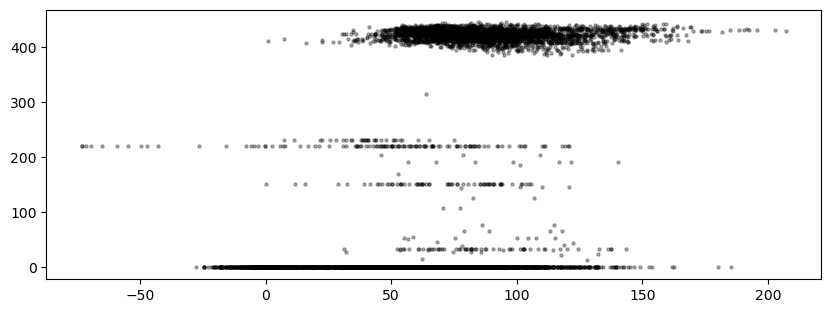

In [76]:
def bmu_analyis(dispatch, prices):

    assert (dispatch.index == prices.index).all()

    df = (
        pd.concat((dispatch, prices), axis=1)
        .rename(columns={0: 'price'})
        .sort_values(by='price', ascending=False)
    )
    df.index = range(len(df))

    fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))

    print(df)
    ax.scatter(df.price.values, df.iloc[:,0], color='k', s=5, alpha=0.3)

    plt.show()


unit = "PEMB-41"

bmu_analyis(bmus[unit], prices)


In [77]:
bmus.sum().sort_values(ascending=False)

ISG-NDPL1    4755888.0
SIZB-1       3432848.0
SIZB-2       3417455.0
HEYM28       3142978.0
HEYM27       3066852.0
               ...    
EAS-BGS01   -2225198.0
EAS-LON01   -2393692.0
STH-LON01   -2534816.0
EAS-EON01   -2680449.0
LON-LON01   -6000638.0
Length: 1935, dtype: float64

In [78]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import argrelextrema

def get_extremes(dispatch, mode='on', neighbour_filter=10):
    """
    Returns indices of timeseries of dispatch in which a generator is switched on or off.
    Works for high-cost peak-demand meeting generators 
    
    Parameters
    ----------
    dispatch : pd.Series
        Timeseries of dispatch
    mode : str, optional
        'on' or 'off', by default 'on'; on to return times of on-switching else off-switching
    """

    if isinstance(dispatch, pd.DataFrame):
        assert len(dispatch.columns) == 0, 'unclear how to handle multiple columns in dispatch dataframe'
        dispatch = dispatch.iloc[:,0]

    if dispatch.max() > 1.:
        dispatch = pd.Series(
            MinMaxScaler().fit_transform(dispatch.values.reshape(-1, 1)).flatten(),
            index=dispatch.index
        )
    
    rounded = dispatch.fillna(0.).round()

    deriv_window_size = 10
    deriv = (
        rounded
        .rolling(deriv_window_size, center=True)
        .apply(lambda x: x[deriv_window_size//2:].mean() - x[:deriv_window_size//2].mean())
    )

    if mode == 'on':
        extreme_func = np.less_equal
    elif mode == 'off':
        extreme_func = np.greater_equal
    else:
        raise ValueError('mode must be either "on" or "off"')

    extremes = np.array(argrelextrema(deriv.values, extreme_func, order=5)[0])

    extremes = extremes[deriv.iloc[extremes] != 0]

    # minor cleanup; remove neighbouring values
    mask = np.abs(np.roll(extremes, 1) - extremes) < neighbour_filter
    mask = mask + np.roll(mask, -1)

    extremes = extremes[~mask]

    return extremes


def get_bmu_price_distribution(
        dispatch,
        prices,
        method='avg',
        visval=False,
        return_length=False,
        **kwargs
        ):
    """Returns a distribution of prices for a timeseries of dispatch for one BMU.
    if method='avg', this is done by taking avg price between on and off switchings.
    if method='on', this is done by taking prices at on-switchings.
    if method='all', this is done by taking all prices."""

    full_index = pd.date_range(prices.index[0], prices.index[-1], freq='30T')

    prices = prices.copy().reindex(full_index).interpolate()
    dispatch = dispatch.copy().reindex(full_index).interpolate()

    dispatch = dispatch.loc[~dispatch.isna()]
    prices = prices.loc[dispatch.index]

    switchons = get_extremes(dispatch, mode='on', **kwargs)
    switchoffs = get_extremes(dispatch, mode='off', **kwargs)

    switchons = pd.Index([dispatch.index[n] for n in switchons])
    switchoffs = pd.Index([dispatch.index[n] for n in switchoffs])

    if visval:

        start = dispatch.index[0]
        if len(dispatch) > 1e3:
            end = dispatch.index[min(len(dispatch)-1, 1000)]

        _, ax = plt.subplots(1, 1, figsize=(10, 3.5))
        ax.plot(dispatch, color='k')
        for on in switchons:
            ax.axvline(on, color='r', linestyle='--')
        for off in switchoffs:
            ax.axvline(off, color='b', linestyle='--')
        ax.set_title(dispatch.name)
        
        ax.set_xlim(start, end)

        ax.set_ylabel('Dispatch [MW]')
        ax.set_xlabel('Time')
        ax.xaxis.set_tick_params(rotation=45)

        plt.show()

    bmu_prices = list()
    lenghts = list()

    if method == 'all':
        offs = list()

    for on in switchons:

        try:
            off = switchoffs[switchoffs > on][0]
        except IndexError:
            continue

        lenghts.append(off - on)

        if method == 'avg':
            bmu_prices.append(prices.loc[on:off].mean())
        else:
            bmu_prices.append(prices.loc[on])

        if method == 'all':
            offs.append(prices.loc[off])
        
    args = [bmu_prices]

    if method == 'all':
        args.append(offs)
    if return_length:
        args.append(lenghts)

    if len(bmu_prices) == 0:
        return np.nan
    else:
        return args


In [79]:
on_prices, off_prices, lengths = get_bmu_price_distribution(
    bmus[unit],
    prices,
    visval=False,
    method='all',
    neighbour_filter=10,
    return_length=True
    )

In [80]:
avg_prices = get_bmu_price_distribution(
    bmus[unit],
    prices,
    visval=False,
    method='avg',
    neighbour_filter=10,
    return_length=False
    )[0]

PearsonRResult(statistic=-0.07313176684708986, pvalue=0.5164511883531526)
PearsonRResult(statistic=-0.2165746272629301, pvalue=0.05213810644453167)
PearsonRResult(statistic=-0.1919259124570918, pvalue=0.086073813829726)


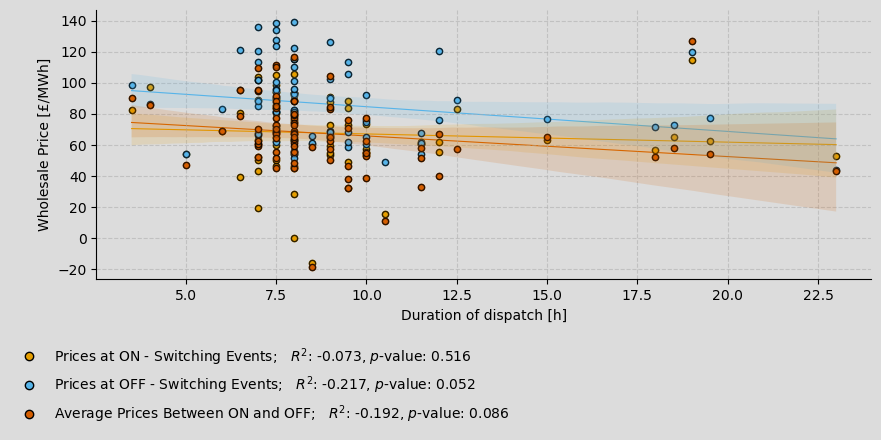

In [167]:
import seaborn as sns
from scipy.stats import pearsonr

background_color = 'gainsboro'

c1, c2, c3 = ["#E69F00", "#56B4E9", "#D55E00"]

df = pd.DataFrame({
    'on': on_prices,
    'off': off_prices,
    'length': lengths,
    'avg_prices': avg_prices,
})
df['length'] = df['length'].apply(lambda x: x.total_seconds() / 60 / 60)

df = df.loc[df['length'] < 24]

fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))

fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

df.plot.scatter(x='length', y='on', ax=ax, color=c1, label='on')
sns.regplot(
    data=df, x='length', y='on', ax=ax, color=c1,
    line_kws={"linewidth": 0.8, "zorder": 0},
    scatter_kws={"s": 20, "alpha": 0.8, "edgecolor": "k"}
    )
print(pearsonr(df['length'], df['on']))
r1, p1 = pearsonr(df['length'], df['on'])

df.plot.scatter(x='length', y='off', ax=ax, color=c2, label='off')
sns.regplot(
    data=df, x='length', y='off', ax=ax, color=c2,
    line_kws={"linewidth": 0.8, "zorder": 0},
    scatter_kws={"s": 20, "alpha": 0.8, "edgecolor": "k"}
    )
print(pearsonr(df['length'], df['off']))
r2, p2 = pearsonr(df['length'], df['off'])

df.plot.scatter(x='length', y='avg_prices', ax=ax, color=c3, label='avg')
sns.regplot(
    data=df, x='length', y='avg_prices', ax=ax, color=c3,
    line_kws={"linewidth": 0.8, "zorder": 0},
    scatter_kws={"s": 20, "alpha": 0.8, "edgecolor": "k"}
    )
print(pearsonr(df['length'], df['avg_prices']))
r3, p3 = pearsonr(df['length'], df['avg_prices'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

from matplotlib.patches import Circle
from matplotlib.lines import Line2D

marker_kwargs = dict(marker='o', color=background_color, markersize=6, markeredgecolor='k')
handles = [
    Line2D([0], [0], markerfacecolor=c1, **marker_kwargs),
    Line2D([0], [0], markerfacecolor=c2, **marker_kwargs),
    Line2D([0], [0], markerfacecolor=c3, **marker_kwargs),
]
formatting = lambda x: f'{x:.3f}'
labels = [
    r"Prices at ON - Switching Events;   $R^2$: {}, $p$-value: {}".format(*map(formatting, [r1, p1])),
    r"Prices at OFF - Switching Events;   $R^2$: {}, $p$-value: {}".format(*map(formatting, [r2, p2])),
    r"Average Prices Between ON and OFF;   $R^2$: {}, $p$-value: {}".format(*map(formatting, [r3, p3])),
]
ax.legend(
    handles,
    labels,
    frameon=False,
    ncol=1,
    bbox_to_anchor=(0.55, -0.2),
)


ax.grid(True, linestyle='--', alpha=0.6)
ax.set_axisbelow(True)

# ax.legend()
ax.set_ylabel('Wholesale Price [£/MWh]')
ax.set_xlabel('Duration of dispatch [h]')

plt.savefig('bmu_price_duration.png', dpi=300, bbox_inches='tight')
plt.show()

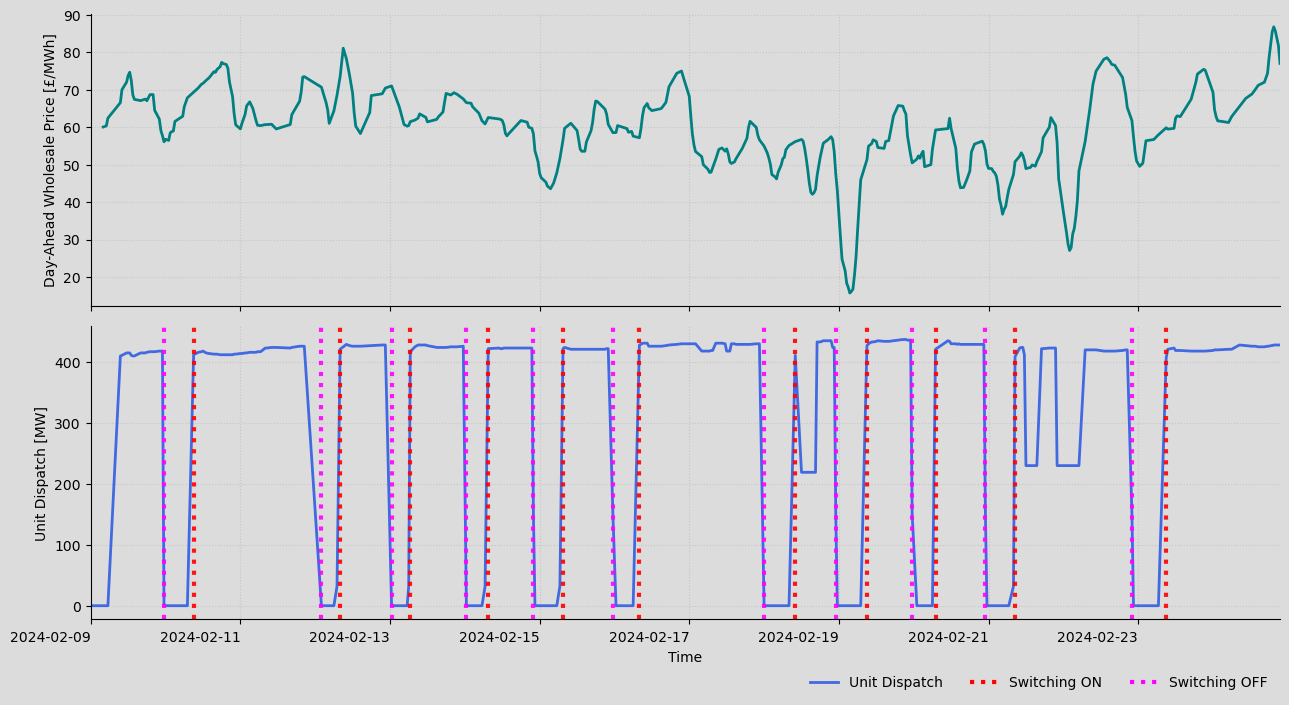

In [135]:
fig, axs = plt.subplots(2, 1, figsize=(13, 7))

fig.patch.set_facecolor(background_color)
for ax in axs:
    ax.set_facecolor(background_color)

linewidth = 2.
# main_color = '#6699CC'
main_color = 'royalblue'

# full_index = pd.date_range(prices.index[0], prices.index[-1], freq='30T')
full_index = pd.date_range(
    '2024-02-09',
    '2024-02-25',
    freq='30T').tz_localize('utc')

full_index = full_index.intersection(prices.index)

prices.loc[full_index].rolling(5).mean().plot(
    ax=axs[0],
    color='teal',
    linewidth=linewidth,
    legend=False
    )
p = bmus.loc[full_index, unit]

switchons = get_extremes(p, mode='on')
switchoffs = get_extremes(p, mode='off')

p.plot(
    ax=axs[1],
    legend=False,
    color=main_color,
    linewidth=linewidth
    )

for i, n in enumerate(switchoffs):

    if i == 0:
        label = 'off'
    else:
        label = None
    axs[1].axvline(p.index[n], color='r', linestyle=':', alpha=0.9, label=label, linewidth=3)

for i, n in enumerate(switchons):

    if i == 0:
        label = 'on'
    else:
        label = None
    axs[1].axvline(p.index[n], color='magenta', linestyle=':', alpha=0.9, label=label, linewidth=3)

switchons = pd.Index([p.index[n] for n in switchons])
switchoffs = pd.Index([p.index[n] for n in switchoffs])

from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], color=main_color, linewidth=linewidth), 
    Line2D([0], [0], color='r', linewidth=3, linestyle=':'), 
    Line2D([0], [0], color='magenta', linewidth=3, linestyle=':'), 
]
labels = [
    'Unit Dispatch',
    'Switching ON',
    'Switching OFF'
    ]



axs[0].set_xticklabels([])
for ax in axs:
    ax.grid(True, linestyle=':', alpha=0.5)
    ax.set_xlim(full_index[0], full_index[-1])

axs[1].legend(
    handles, labels,
    frameon=False,
    ncol=3,
    fontsize=10,
    bbox_to_anchor=(1.0, -0.15)
)

axs[0].set_ylabel("Day-Ahead Wholesale Price [£/MWh]")
axs[1].set_ylabel("Unit Dispatch [MW]")

axs[1].tick_params(axis='x', rotation=0, pad=5)
axs[1].set_xlabel("Time")

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig('price_dispatch.png', dpi=300)
plt.show()

In [ ]:
get_bmu_price_distribution(p, prices, visval=True, neighbour_filter=10)

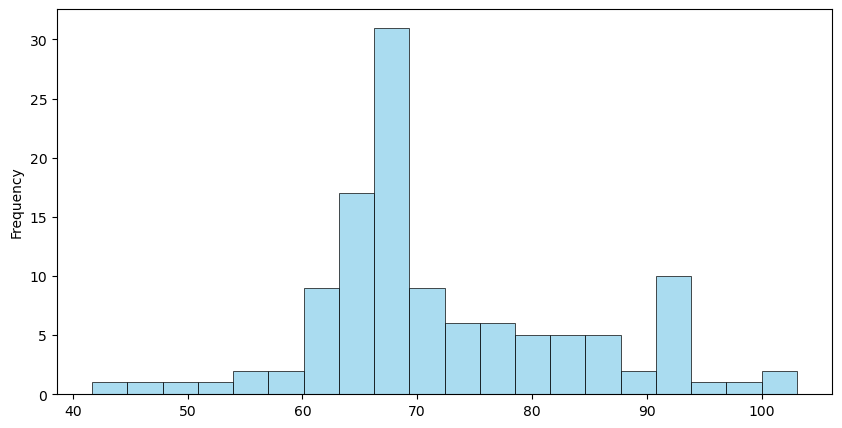

In [16]:
costs = pd.read_csv(Path.cwd().parent / 'resources' / 'bmu_cost_estimates.csv', index_col=0).rename(columns={'0': 'cost'})['cost']

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
costs.plot.hist(bins=20, ax=ax, edgecolor='k', alpha=0.7, color='skyblue', linewidth=0.7)

plt.show()

DatetimeIndex(['2024-02-10 23:00:00', '2024-02-11 23:00:00',
               '2024-02-12 23:00:00', '2024-02-13 21:30:00',
               '2024-02-14 09:00:00', '2024-02-14 21:00:00',
               '2024-02-15 22:00:00', '2024-02-17 11:30:00',
               '2024-02-17 21:00:00', '2024-02-18 21:00:00',
               '2024-02-19 11:00:00', '2024-02-19 22:00:00',
               '2024-02-20 21:00:00'],
              dtype='datetime64[ns]', freq=None)

In [7]:
bmu_data = pd.read_csv(Path.cwd().parent / 'resources' / 'bmunits_loc.csv', index_col=0)
print(bmu_data.carrier.unique())

[nan 'gas-fired' 'supply' 'battery' 'gas' 'onwind' 'hydro' 'hydro-scheme'
 'wind' 'biomass' 'offwind' 'CHP' 'CCGT' 'floating wind' 'oil' 'coal'
 'submarine power cable' 'gas turbine' 'powerstation' 'interconnector'
 'HVDC submarine' 'cascade' 'steel mill' 'business' 'PV' 'PHS' 'nuclear'
 'dam' 'solar power station' 'natural gas processing']


In [8]:
dispatchers = (
    (b := (
        pd.concat((
            bmu_data.loc[bmu_data.index.intersection(bmus.columns)],
            bmus.sum()
        ), axis=1)
        .rename(columns={0: 'generation'})
        .sort_values(by='generation', ascending=False)
    ))
    .loc[
        (b["carrier"].isin(['gas', 'CCGT', 'biomass', 'coal', 'CHP', 'gas turbine', 'powerstation']))
        & (b["generation"] > 0.)
    ]
)
total_generation = dispatchers.generation.sum()

In [293]:
dispatchers.loc[dispatchers.generation > 0.].tail(30)

,lat,lon,capacity,carrier,generation
WTRLN-1,0.000000,0.000000,19.0,powerstation,4150.0
FDUNT-1,53.071393,-1.349033,100.0,gas,3763.0
KILLPG-2,53.659520,-0.255110,600.0,CCGT,3658.0
BRIDU-1,54.086555,-0.203475,0.0,gas,3530.0
SOLUU-1,50.745900,-1.286400,0.0,gas,3161.0
TDRVE-1,0.000000,0.000000,6.0,gas,3037.0
ABERU-1,53.090486,-1.270137,10.0,gas,2877.0
SEVIU-1,51.587736,-2.998323,10.0,gas,2712.0
LSTWY-1,0.000000,0.000000,12.0,gas,2590.0
BURGH-1,0.000000,0.000000,45.0,gas,2390.0


In [16]:
switchons

DatetimeIndex(['2024-02-10 23:00:00', '2024-02-11 23:00:00',
               '2024-02-12 23:00:00', '2024-02-13 21:30:00',
               '2024-02-14 09:00:00', '2024-02-14 21:00:00',
               '2024-02-15 22:00:00', '2024-02-17 11:30:00',
               '2024-02-17 21:00:00', '2024-02-18 21:00:00',
               '2024-02-19 11:00:00', '2024-02-19 22:00:00',
               '2024-02-20 21:00:00'],
              dtype='datetime64[ns]', freq=None)

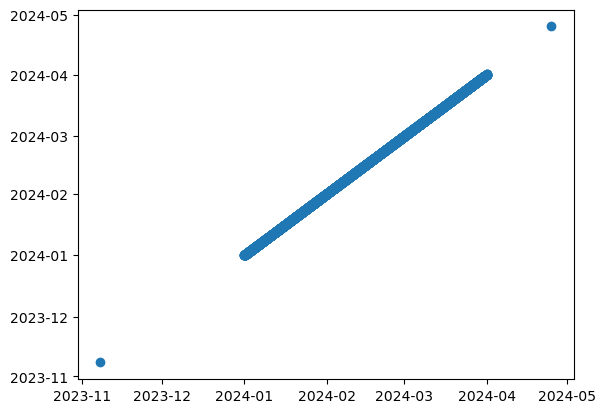

In [7]:
plt.scatter(prices.index, prices.index)

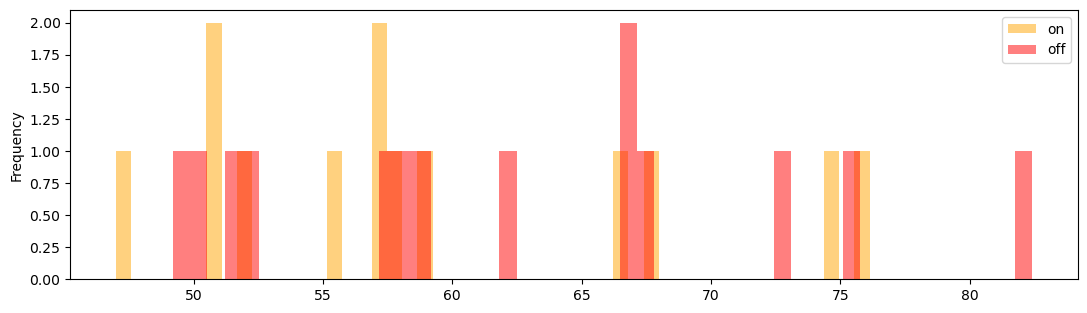

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(13, 3.5))

prices.loc[switchons].plot.hist(ax=ax, bins=50, alpha=0.5, color='orange', label='on')
prices.loc[switchoffs].plot.hist(ax=ax, bins=50, alpha=0.5, color='r', label='off')
# pd.Series(avg_prices).plot.hist(ax=ax, bins=50, alpha=0.5, color='k', label='avg')

ax.legend()
plt.show()

In [18]:
results = {}
# for unit in ["DRAXX-1", "STAY-2", "MRWD-1", "HUMR-1", "DIDCB5", "SPLN-1", "KEAD-2", "PEHE-1", "LAGA-1", "PEMB-51", "GRAI-7"]:
for unit in ['KILLPG-2']:

    print('dispatch')
    print(bmus[unit])
    print('prices')
    print(prices)
    print(type(prices))

    assert False

    results[unit] = pd.Series(get_bmu_price_distribution(bmus[unit], prices, visval=True, neighbour_filter=5))

fig, ax = plt.subplots(1, 1, figsize=(13, 3.5))
for unit in results:
    results[unit].plot.hist(ax=ax, bins=20, alpha=0.5, label=unit)
ax.legend()
plt.show()

dispatch
2023-10-01 01:00:00    0.0
2023-10-01 05:30:00    0.0
2023-10-01 06:00:00    0.0
2023-10-01 06:30:00    0.0
2023-10-01 07:00:00    0.0
                      ... 
2024-04-06 03:00:00    0.0
2024-04-06 03:30:00    0.0
2024-04-06 04:00:00    0.0
2024-04-06 04:30:00    0.0
2024-04-06 05:00:00    0.0
Name: KILLPG-2, Length: 8191, dtype: float64
prices
2023-10-01 01:00:00    97.26
2023-10-01 05:30:00    72.37
2023-10-01 06:00:00    84.38
2023-10-01 06:30:00    84.28
2023-10-01 07:00:00    82.16
                       ...  
2024-04-06 03:00:00     6.28
2024-04-06 03:30:00    -8.80
2024-04-06 04:00:00   -14.67
2024-04-06 04:30:00   -17.55
2024-04-06 05:00:00   -19.86
Length: 8191, dtype: float64
<class 'pandas.core.series.Series'>


AssertionError: 

#### Get Cost Distribution on Balancing Markets

In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path 
import matplotlib.pyplot as plt

In [3]:
os.listdir(Path.cwd().parent / 'data')

['agg_p_nom_minmax.csv',
 'attributed_ports.json',
 'base.nc',
 'bmu_operation_winter.csv',
 'bundle',
 'charge_restriction_regions.geojson',
 'charge_restriction_regions_raw.geojson',
 'costs_2020.csv',
 'custom_extra_functionality.py',
 'custom_powerplants.csv',
 'district_heat_share.csv',
 'eia_hydro_annual_generation.csv',
 'entsoegridkit',
 'eso_zonal_shapes.geojson',
 'eso_zones.geojson',
 'ETYS Appendix B 2022.xlsx',
 'ETYS23 Appendix F - generation data_0.xlsx',
 'ETYS23 Appendix G_1.xlsx',
 'ETYS_base.nc',
 'existing_infrastructure',
 'FES-2021--Falling_Short--demandpk-all--gridsupplypoints.csv',
 'FES-2021--Leading_the_Way--demandpk-all--gridsupplypoints.csv',
 'fes2023_regional_breakdown_gsp_info.csv',
 'fti_zonal_shapes.geojson',
 'fti_zones.geojson',
 'gb_admin_zones',
 'GB_network.xlsx',
 'gb_shape.geojson',
 'GDP_PPP_30arcsec_v3_mapped_default.csv',
 'geth2015_hydro_capacities.csv',
 'gsp_geometries.geojson',
 'gsp_gnode_directconnect_region_lookup.csv',
 'heat_load_prof

In [10]:
from itertools import product

days = pd.date_range('2024-01-01', '2024-04-25', freq='d')
fn = 'much_balancing.sh'

template = "snakemake -call --configfile config/config.yaml -- resources/live_data/{}_{}/real_balancing_actions.csv\n"

with open(fn, 'w') as file:
    for day, period in product(days, range(1, 49)):

        day = day.strftime('%Y-%m-%d')
        file.write(template.format(day, period))


os.chmod(fn, 0o755)



In [101]:
actions = list()
dates = list()

template = "../resources/live_data/{}_{}/real_balancing_actions.csv"

for day, period in product(days, range(1, 49)):

    try:
        day = day.strftime('%Y-%m-%d')
        actions.append(pd.read_csv(template.format(day, period), index_col=0))
        dates.append(pd.Timestamp(day) + pd.Timedelta((period-1)*30, 'm'))
    except FileNotFoundError:
        continue


In [ ]:
dates

In [108]:
import numpy as np

summary = pd.concat([a.stack().rename(dates[i]) for i, a in enumerate(actions) if not a.empty], axis=1)
# summary.columns = dates

summary.astype(np.float16).to_csv('winter_2024_balancing_actions.csv')

c:\Users\lukas\miniforge3\envs\pypsa-eur\lib\site-packages\pandas\core\dtypes\astype.py:138: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


In [38]:
# revs = pd.concat([a for a in actions if not a.empty], axis=1)
revs = pd.concat([a[["offer revenue", "bid revenue"]].stack() for a in actions if not a.empty], axis=1)
prices = pd.concat([a[["offer price", "bid price"]].stack() for a in actions if not a.empty], axis=1)

In [49]:
idx = pd.IndexSlice

results = pd.DataFrame(columns=["offer_cost", "offer_vol", "bid_cost", "bid_vol"])

for bmu in revs.index.get_level_values(0).unique():

    # print(bmu)
    rev = revs.loc[idx[bmu, :], :]    
    price = prices.loc[idx[bmu, :], :]

    rev = rev.loc[:, ~rev.isna().all(axis=0)]
    price = price.loc[:, rev.columns]

    # print(rev)
    # print(price)

    vol = pd.DataFrame(rev.values / price.values, index=rev.index, columns=rev.columns)
    offer_col, bid_vol = vol.sum(axis=1).values

    # print(vol)
    vol = vol.div(vol.sum(axis=1), axis=0)

    # print('-------------------')
    # print(vol)
    # print(vol.sum(axis=1))

    weighted_avg = (vol.values * price.values).sum(axis=1)
    results.loc[bmu] = pd.Series({
        "offer_cost": weighted_avg[0],
        "offer_vol": offer_col,
        "bid_cost": weighted_avg[1],
        "bid_vol": bid_vol,
    })


C:\Users\lukas\AppData\Local\Temp\ipykernel_20484\3204876226.py:17: RuntimeWarning: invalid value encountered in divide
  vol = pd.DataFrame(rev.values / price.values, index=rev.index, columns=rev.columns)
C:\Users\lukas\AppData\Local\Temp\ipykernel_20484\3204876226.py:17: RuntimeWarning: invalid value encountered in divide
  vol = pd.DataFrame(rev.values / price.values, index=rev.index, columns=rev.columns)
C:\Users\lukas\AppData\Local\Temp\ipykernel_20484\3204876226.py:17: RuntimeWarning: invalid value encountered in divide
  vol = pd.DataFrame(rev.values / price.values, index=rev.index, columns=rev.columns)
C:\Users\lukas\AppData\Local\Temp\ipykernel_20484\3204876226.py:17: RuntimeWarning: invalid value encountered in divide
  vol = pd.DataFrame(rev.values / price.values, index=rev.index, columns=rev.columns)
C:\Users\lukas\AppData\Local\Temp\ipykernel_20484\3204876226.py:17: RuntimeWarning: invalid value encountered in divide
  vol = pd.DataFrame(rev.values / price.values, index=re

In [66]:
results

,offer_cost,offer_vol,bid_cost,bid_vol
MRWD-1,108.809856,3781.054884,80.00,0.001759
AKGLW-3,NaN,0.000000,68.00,5828.740833
ASHWW-1,NaN,0.000000,75.00,2026.933333
DRAXX-3,146.327072,9009.750000,NaN,0.000000
SGRWO-6,1500.000000,348.371982,100.00,77409.601019
...,...,...,...,...
LNCSO-2,NaN,0.000000,173.73,26.630556
GRGBW-3,NaN,0.000000,182.73,4.200000
GRGBW-2,NaN,0.000000,182.73,4.533333
GRGBW-1,NaN,0.000000,182.73,4.000000


In [55]:
print(results[['offer_vol', "offer_cost"]].sort_values(by='offer_vol', ascending=False).head(20))
print(results[['bid_vol', "bid_cost"]].sort_values(by='bid_vol', ascending=False).head(20))

            offer_vol  offer_cost
SEAB-1   50668.583850  102.231626
PEMB-51  35982.755676  154.080024
LAGA-1   34463.491712  171.986908
DIDCB5   26811.486547  109.847175
DRAXX-2  15428.000000  145.283745
KEAD-2   14537.512913   81.762257
SEAB-2   12769.626719  146.411261
PEMB-21  11543.428525  153.638147
LBAR-1   10222.023977  131.139189
CARR-2    9370.058599  119.269262
DRAXX-3   9009.750000  146.327072
RATS-3    7393.212496   86.984660
STAY-3    6828.095733  134.368895
DRAXX-4   6299.301860  140.551083
RATS-2    5739.616164   89.985302
PEMB-31   5550.964972  153.714416
CNQPS-1   4338.281020   92.355848
MRWD-1    3781.054884  108.809856
CARR-1    3656.533368  135.000000
CNQPS-2   3546.110991   96.285065
               bid_vol     bid_cost
PEHE-1   125645.565649    91.802897
SGRWO-6   77409.601019   100.000000
SGRWO-1   63795.605573   100.000000
FOYE-1    37893.510974    82.959105
SGRWO-3   32415.791112   100.000000
SGRWO-4   29021.025518   100.000000
MOWEO-3   25831.090723  9942.19137

In [78]:
import pypsa

n = pypsa.Network(Path.cwd().parent / 'resources' / 'live_data' / '2024-03-01_10' / 'network.nc')
print(n.generators.carrier.unique())

ren_carriers = [
    'onwind',
    'offwind',
    'wind',
    'hydro',
    'hydro-scheme',
    'floating wind',
]

Index(['BLARW-1'], dtype='object', name='name')
Index(['5190', '6062', '6067', '6071', '6072', '7800', '7197'], dtype='object', name='name')
INFO:pypsa.io:Imported network network.nc has buses, carriers, generators, lines, links, loads, transformers


['gas-fired' 'gas' 'onwind' 'hydro' 'hydro-scheme' 'wind' 'offwind'
 'battery' 'CHP' 'floating wind' 'coal' 'biomass' 'gas turbine'
 'interconnector' 'cascade' 'CCGT' 'nuclear' 'powerstation']


In [79]:
offer_results = results.loc[results["offer_vol"] > 0]
bid_results = results.loc[results["bid_vol"] > 0]

offinter = offer_results.index.intersection(ests.index)
bidinter = bid_results.index.intersection(ests.index)
renewable_bidinter = n.generators.loc[n.generators.carrier.isin(ren_carriers)].index.intersection(bid_results.index)

offer_total = pd.concat((
    ests.rename('wholesale cost').loc[offinter], 
    offer_results.loc[offinter, ['offer_cost', 'offer_vol']],
), axis=1)

dispatch_bid_total = pd.concat((
    ests.rename('wholesale cost').loc[bidinter], 
    bid_results.loc[bidinter, ['bid_cost', 'bid_vol']],
), axis=1)

renewable_bid_total = pd.concat((
    n.generators.loc[renewable_bidinter, 'marginal_cost'].rename('wholesale cost'), 
    bid_results.loc[renewable_bidinter, ['bid_cost', 'bid_vol']],
), axis=1)


In [82]:
renewable_bid_total.sort_values(by='bid_vol', ascending=False).head(20)

,wholesale cost,bid_cost,bid_vol
SGRWO-6,0.01,100.000000,77409.601019
SGRWO-1,0.01,100.000000,63795.605573
SGRWO-3,0.01,100.000000,32415.791112
SGRWO-4,0.01,100.000000,29021.025518
MOWEO-3,0.01,9942.191370,25831.090723
MOWEO-1,0.01,9884.142327,25811.100388
MOWEO-2,0.01,9907.912270,24654.924214
SGRWO-5,0.01,100.124590,16560.505204
SGRWO-2,0.01,100.000000,14677.785563
LCSMH-1,20.00,49.950000,9656.737500


In [94]:
total = pd.concat((offer_total, dispatch_bid_total, renewable_bid_total), axis=0).drop_duplicates()
total = total.groupby(total.index).first()
total = (
    pd.concat((
        total,
        n.generators.loc[total.index.intersection(n.generators.index), 'carrier']
        ), axis=1)
)

In [97]:
total.groupby('carrier').median()

,wholesale cost,offer_cost,offer_vol,bid_cost,bid_vol
carrier,,,,,
CCGT,63.737948,153.676282,4944.622996,65.000000,5.775580
biomass,46.422813,145.283745,9009.750000,60.000000,33.583333
coal,61.162403,92.492330,3811.606248,36.070000,0.400000
gas,65.385076,108.809856,1606.462331,70.000000,33.712261
hydro,20.000000,NaN,NaN,70.275303,3845.781241
hydro-scheme,20.000000,NaN,NaN,103.645000,1122.269021
offwind,0.010000,NaN,NaN,178.875000,397.262500
onwind,0.010000,NaN,NaN,91.990000,1471.495139
wind,0.010000,NaN,NaN,85.000000,2170.058333


In [5]:
date = '2024-01'

pd.date_range(start=date, end=pd.to_datetime(date) + pd.offsets.MonthEnd(1), freq='d')

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12',
               '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16',
               '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-20',
               '2024-01-21', '2024-01-22', '2024-01-23', '2024-01-24',
               '2024-01-25', '2024-01-26', '2024-01-27', '2024-01-28',
               '2024-01-29', '2024-01-30', '2024-01-31'],
              dtype='datetime64[ns]', freq='D')